<a href="https://colab.research.google.com/github/yazeedbukhari/BIRAD-classification/blob/main/Baseline_Model_Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Since the progress report, the team has worked on improving data processing; after further improvements were made, the team was able to process all mammogram images such that they are 224x224 pixels.

In [ ]:
#Importing

import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

import os
import shutil
import random

In [ ]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
use_cuda = True

# Splitting Data for Train/Validation/Testing

In [ ]:
import os
import shutil
import random

source_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Source_Folder/'
train_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Train_Folder/'
val_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Val_Folder/'
test_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Test_Folder/'

subfolders = os.listdir(source_folder)

for BIRAD in subfolders:
    # Create class subfolders in each dataset folder
    os.makedirs(train_folder + BIRAD, exist_ok=True)
    os.makedirs(val_folder + BIRAD, exist_ok=True)
    os.makedirs(test_folder + BIRAD, exist_ok=True)

    # List and shuffle files
    files = os.listdir(source_folder + BIRAD)
    random.shuffle(files)

    # Calculate split indices
    train_split = int(0.7 * len(files))
    val_split = train_split + int(0.2 * len(files))

    # Move files to respective folders
    for i, file in enumerate(files):
        source_path = os.path.join(source_folder, BIRAD, file)
        if i < train_split:
            destination_path = os.path.join(train_folder, BIRAD, file)
        elif i < val_split:
            destination_path = os.path.join(val_folder, BIRAD, file)
        else:
            destination_path = os.path.join(test_folder, BIRAD, file)

        shutil.move(source_path, destination_path)

# Architecture

In [ ]:
# Defining Paths for Dataset Testing

import torchvision.transforms as transforms

train_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Train_Folder/'
val_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Val_Folder/'
test_folder = '/content/drive/MyDrive/APS360_Fall/Project_2/Project_Test_Folder/'

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])

train_set = torchvision.datasets.ImageFolder(train_folder, transform = transform)
val_set = torchvision.datasets.ImageFolder(val_folder, transform = transform)
test_set = torchvision.datasets.ImageFolder(test_folder, transform = transform)


In [ ]:
# Baseline Model Architecture

class BaselineModel(nn.Module):
    def __init__(self, name = "Baseline"):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 2) # Starting with 3 channels (RGB), output of first conv layer has 8 channels, kernel size of 5 (more general features), stride = 1, padding of 2 (same padding)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 12, 3, 1, 2) # 8 input channels, 12 output channels, kernel size of 3 (finer details), stride = 1, padding of 2 (same padding)
        self.fc1 = nn.Linear(12 * 57 * 57, 32)
        self.fc2 = nn.Linear(32, 5)

        self.name = name

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 57 * 57)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

# Metric Code and Training Code

In [ ]:
def get_accuracy(model, data_loader):

    correct = 0
    total = 0

    for imgs, labels in data_loader:

        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score (This is for multi-class)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [ ]:
def get_model_name(name, batch_size, lr, num_epochs):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_num_epoch{3}".format(name,
                                                   batch_size,
                                                   lr,
                                                   num_epochs)
    return path

In [ ]:
# Training Code

def train(model, train_set, val_set, batch_size=64, num_epochs=32, lr=0.001):
    torch.manual_seed(10)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        model_path = get_model_name(model.name, batch_size, lr, epoch)
        torch.save(model.state_dict(), model_path)

        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        n += 1

    epochs = np.arange(1, num_epochs + 1)

    return train_acc, val_acc, epochs

# Training/Evaluation

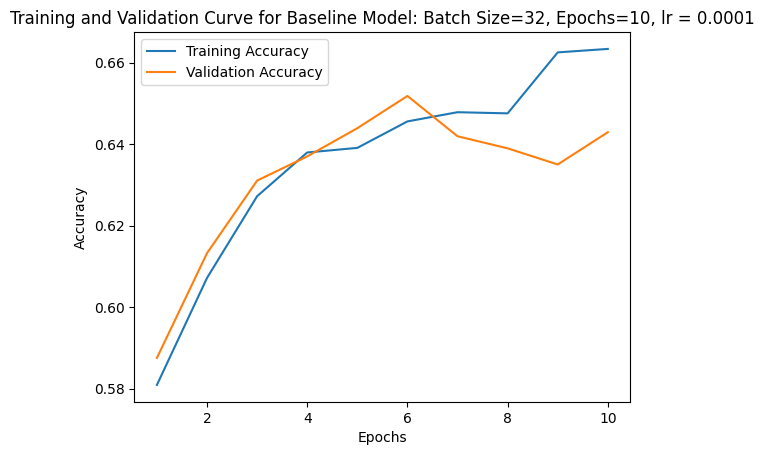

In [ ]:
Baseline1 = BaselineModel(name="Baseline1")
if use_cuda and torch.cuda.is_available():
  Baseline1.cuda()

train_acc, val_acc, epochs = train(Baseline1, train_set, val_set, batch_size = 32, num_epochs = 10, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=10, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

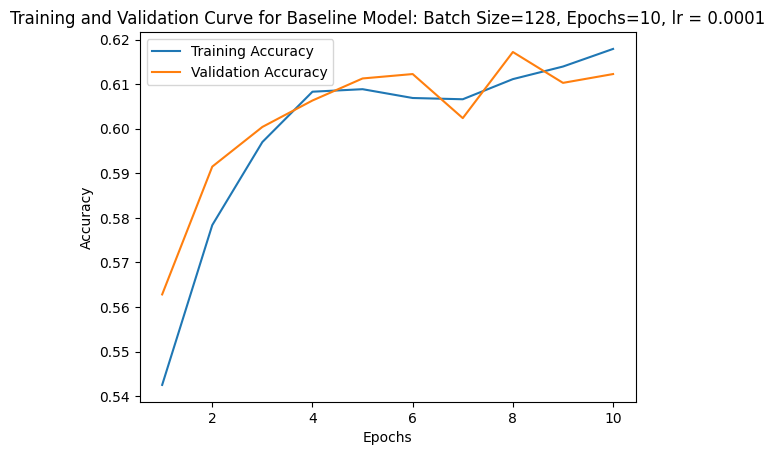

In [ ]:
Baseline2 = BaselineModel(name="Baseline2")
if use_cuda and torch.cuda.is_available():
  Baseline2.cuda()

train_acc, val_acc, epochs = train(Baseline2, train_set, val_set, batch_size = 128, num_epochs = 10, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=128, Epochs=10, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

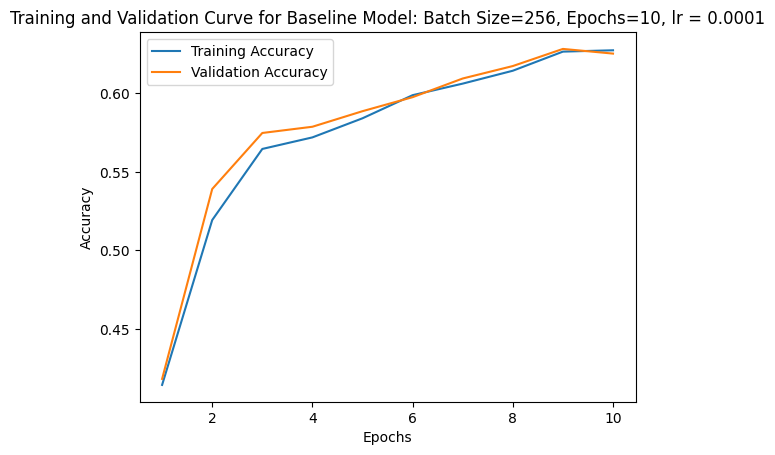

In [ ]:
Baseline3 = BaselineModel(name="Baseline3")
if use_cuda and torch.cuda.is_available():
  Baseline3.cuda()

train_acc, val_acc, epochs = train(Baseline3, train_set, val_set, batch_size = 256, num_epochs = 10, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=256, Epochs=10, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

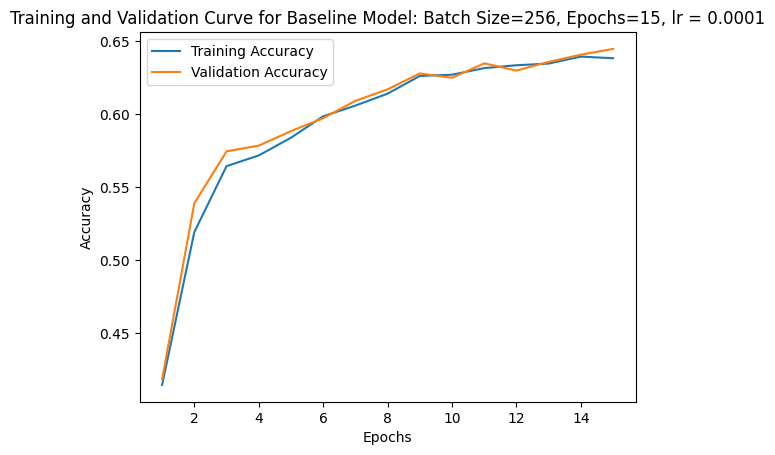

In [ ]:
Baseline4 = BaselineModel(name="Baseline4")
if use_cuda and torch.cuda.is_available():
  Baseline4.cuda()

train_acc, val_acc, epochs = train(Baseline4, train_set, val_set, batch_size = 256, num_epochs = 15, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=256, Epochs=15, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

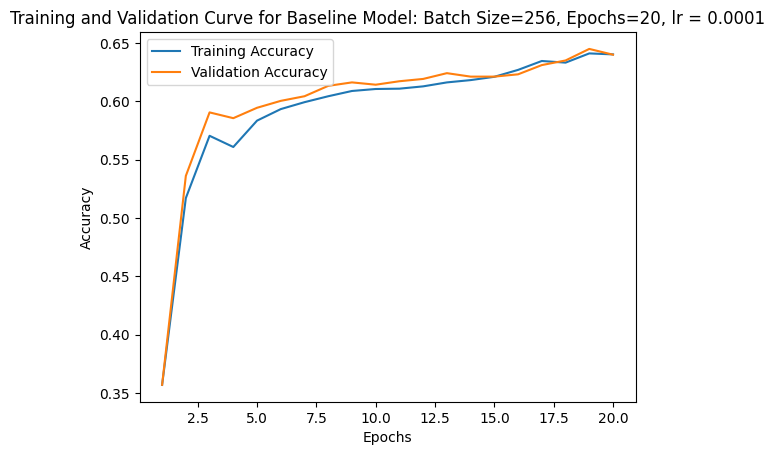

In [ ]:
Baseline5 = BaselineModel(name="Baseline5")
if use_cuda and torch.cuda.is_available():
  Baseline5.cuda()

train_acc, val_acc, epochs = train(Baseline5, train_set, val_set, batch_size = 256, num_epochs = 20, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=256, Epochs=20, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

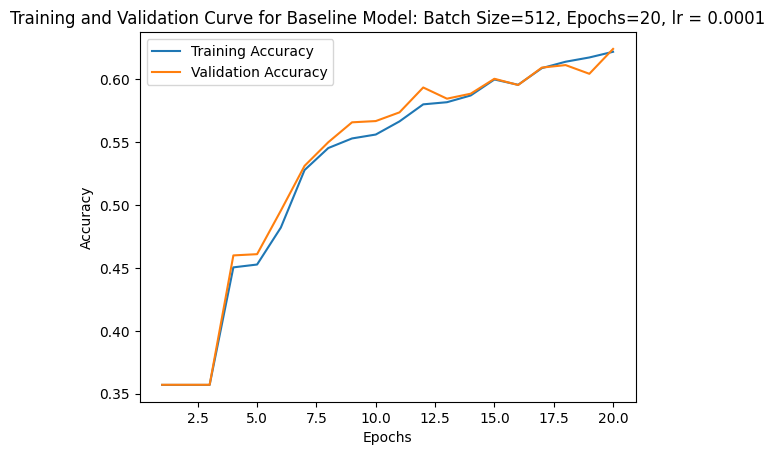

In [ ]:
Baseline6 = BaselineModel(name="Baseline6")
if use_cuda and torch.cuda.is_available():
  Baseline6.cuda()

train_acc, val_acc, epochs = train(Baseline6, train_set, val_set, batch_size = 512, num_epochs = 20, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=512, Epochs=20, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

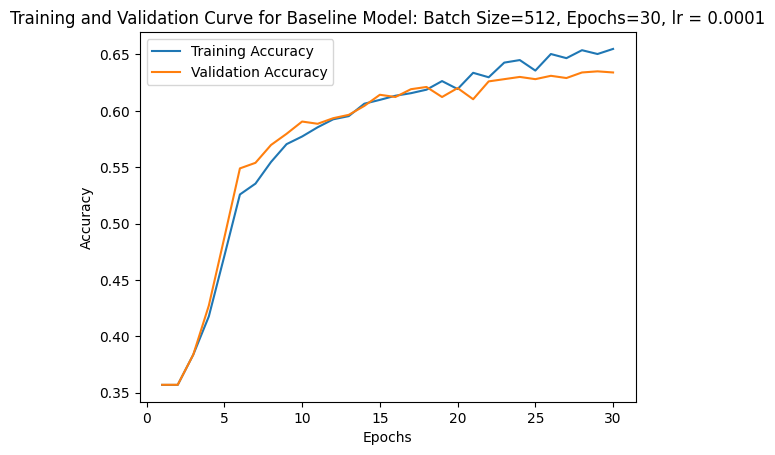

In [ ]:
Baseline7 = BaselineModel(name="Baseline7")
if use_cuda and torch.cuda.is_available():
  Baseline7.cuda()

train_acc, val_acc, epochs = train(Baseline7, train_set, val_set, batch_size = 512, num_epochs = 30, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=512, Epochs=30, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

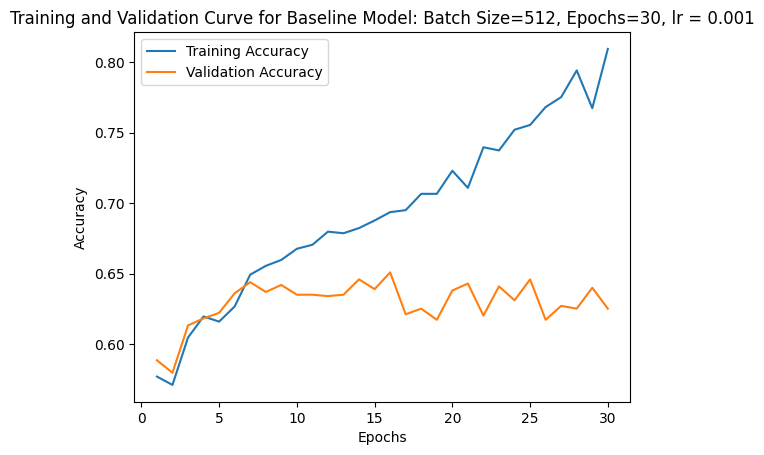

In [ ]:
Baseline8 = BaselineModel(name="Baseline8")
if use_cuda and torch.cuda.is_available():
  Baseline8.cuda()

train_acc, val_acc, epochs = train(Baseline8, train_set, val_set, batch_size = 512, num_epochs = 30, lr = 0.001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=512, Epochs=30, lr = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

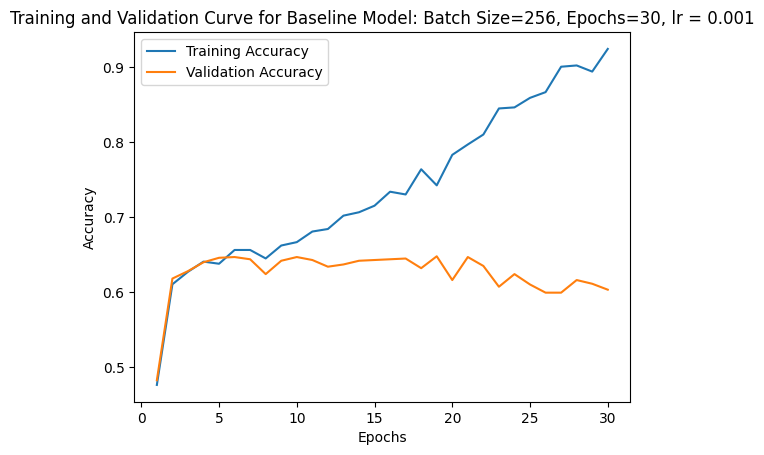

In [ ]:
Baseline9 = BaselineModel(name="Baseline9")
if use_cuda and torch.cuda.is_available():
  Baseline9.cuda()

train_acc, val_acc, epochs = train(Baseline9, train_set, val_set, batch_size = 256, num_epochs = 30, lr = 0.001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=256, Epochs=30, lr = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

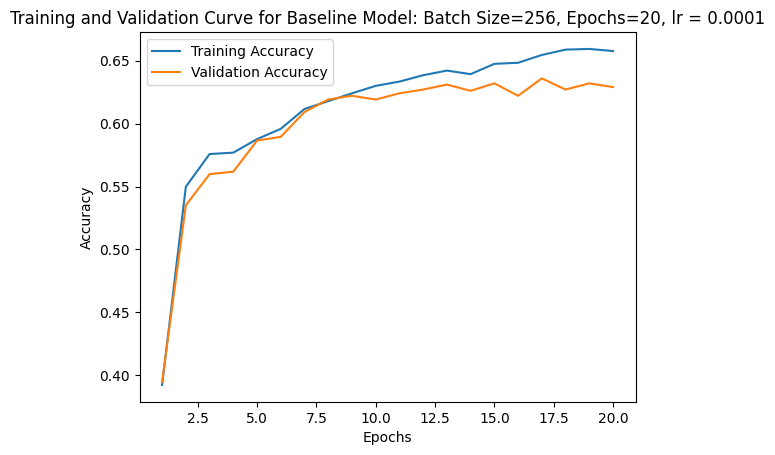

In [ ]:
BaselineFinal = BaselineModel(name="BaselineFinal")
if use_cuda and torch.cuda.is_available():
  BaselineFinal.cuda()

train_acc, val_acc, epochs = train(BaselineFinal, train_set, val_set, batch_size = 256, num_epochs = 20, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=256, Epochs=20, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Final Baseline Model/Validation Confusion Matrix

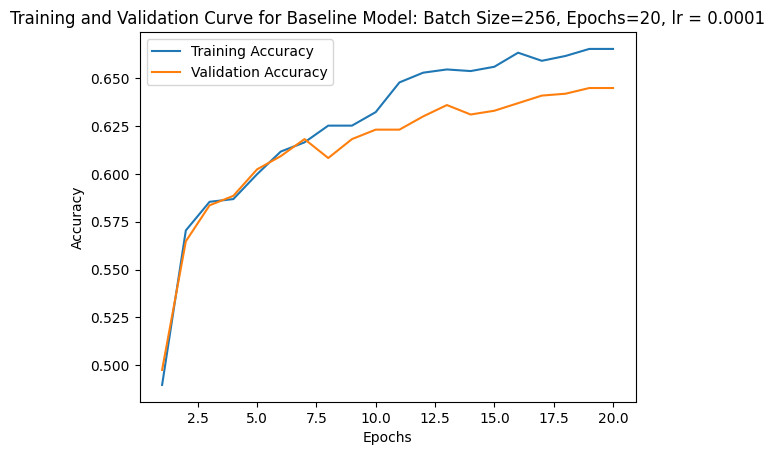

In [ ]:
Baseline_Final = BaselineModel(name="Baseline_Final")
if use_cuda and torch.cuda.is_available():
  Baseline_Final.cuda()

train_acc, val_acc, epochs = train(Baseline_Final, train_set, val_set, batch_size = 256, num_epochs = 20, lr = 0.0001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=256, Epochs=20, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Testing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Modifying get_accuracy code to keep track of true labels and predictions for the test set...

def get_accuracy_test(model, data_loader):

    correct = 0
    total = 0

    true_labels = []
    predicted_labels = []

    for imgs, labels in data_loader:

        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score (This is for multi-class)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        true_labels.extend(labels.tolist())
        predicted_labels.extend(pred.tolist())

    accuracy = correct / total

    return accuracy, true_labels, predicted_labels

In [ ]:
Baseline_Final = BaselineModel(name="Baseline_Final")
if use_cuda and torch.cuda.is_available():
  Baseline_Final.cuda()

model_path = get_model_name(Baseline_Final.name, batch_size=256, lr=0.0001, num_epochs=19)
state = torch.load(model_path)
Baseline_Final.load_state_dict(state)

<All keys matched successfully>

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

test_accuracy, true_labels_test, predicted_labels_test = get_accuracy_test(Baseline_Final, test_loader)

print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.6333


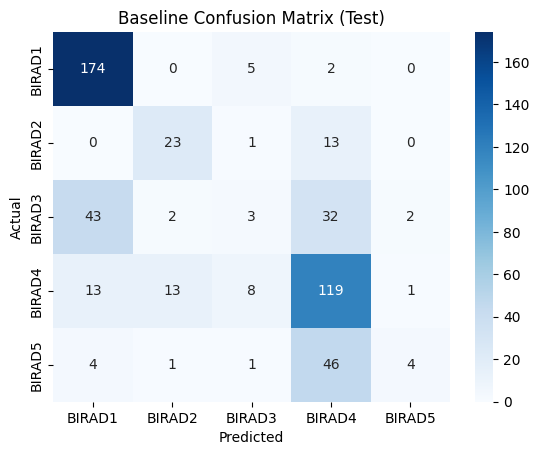

In [ ]:
# Compute and print the confusion matrix
cm = confusion_matrix(true_labels_test, predicted_labels_test)

classes = ["BIRAD1", "BIRAD2", "BIRAD3", "BIRAD4", "BIRAD5"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Baseline Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Compute precision, recall, and f1 score
precision = precision_score(true_labels_test, predicted_labels_test, average='weighted')
recall = recall_score(true_labels_test, predicted_labels_test, average='weighted')
f1 = f1_score(true_labels_test, predicted_labels_test, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

report = classification_report(true_labels_test, predicted_labels_test, target_names=classes)
print(report)

Precision: 0.5657
Recall: 0.6333
F1 Score: 0.5615
              precision    recall  f1-score   support

      BIRAD1       0.74      0.96      0.84       181
      BIRAD2       0.59      0.62      0.61        37
      BIRAD3       0.17      0.04      0.06        82
      BIRAD4       0.56      0.77      0.65       154
      BIRAD5       0.57      0.07      0.13        56

    accuracy                           0.63       510
   macro avg       0.53      0.49      0.46       510
weighted avg       0.57      0.63      0.56       510



# Overfit Testing

In [ ]:
#### Not sure if I need to do this again... Can probably just use from progress report...